<a href="https://colab.research.google.com/github/Harshini-19-git/projects/blob/main/AI_vs_Real_Image_classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
print("All files extensions have been added successfully")


All files extensions have been added successfully


In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import os
import PIL

In [14]:
!pip install -q kaggle


In [15]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"harshinip2","key":"0bf52e5144f04d5138c15eb967da7d05"}'}

In [23]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [24]:
!kaggle datasets list -s cifake


ref                                                         title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
birdy654/cifake-real-and-ai-generated-synthetic-images      CIFAKE: Real and AI-Generated Synthetic Images    109625224  2023-03-28 16:00:29.500000          23964        165  0.875            
mariammarioma/midjourney-cifake-inspired                    Midjourney CIFAKE-Inspired                       2983770220  2024-04-14 18:50:52.243000            167          6  0.6875           
superpotato9/dalle-recognition-dataset                      AI recognition dataset                          14400638748  2024-01-29 01:35:56.560000           2182         25  0.875            
gauravduttakiit/cifake-efficientnet

In [25]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images


Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.45GB/s]


#train test creation

In [26]:
# Make a directory inside working (writable)
!mkdir -p /kaggle/working/cifake

# Unzip dataset into that directory
!unzip -o cifake-real-and-ai-generated-synthetic-images.zip -d /kaggle/working/cifake

# Verify files
!ls /kaggle/working/cifake




Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/working/cifake/train/REAL/4500 (2).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500 (3).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500 (4).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500 (5).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500 (6).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500 (7).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500 (8).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500 (9).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4500.jpg  
  inflating: /kaggle/working/cifake/train/REAL/4501 (10).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4501 (2).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4501 (3).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4501 (4).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4501 (5).jpg  
  inflating: /kaggle/working/cifake/train/REAL/4501 (6).jpg  
  inflating: /kaggle/w

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/cifake/train",
    image_size=(64, 64),   # or 32x32 depending on dataset
    batch_size=32
).map(lambda x, y: (x/255.0, y))  # normalize here

test = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/cifake/test",
    image_size=(64, 64),
    batch_size=32
).map(lambda x, y: (x/255.0, y))

train = train.shuffle(1000).prefetch(AUTOTUNE)
test = test.prefetch(AUTOTUNE)


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [30]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [32]:
personal_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/images",
    image_size=(64, 64),  # match your existing dataset
    batch_size=32,
    shuffle=True
).map(lambda x, y: (x/255.0, y))  # normalize images


Found 716 files belonging to 2 classes.


In [33]:
train = train.concatenate(personal_ds)
train = train.shuffle(1000).prefetch(tf.data.AUTOTUNE)


In [34]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

train = train.map(lambda x, y: (data_augmentation(x), y))


## Model creation

In [35]:
import numpy as np
from sklearn.utils import class_weight

num_classes = 2  # change as per your dataset
counts = np.zeros(num_classes)

for x_batch, y_batch in train:
    y_np = y_batch.numpy()
    for i in range(num_classes):
        counts[i] += np.sum(y_np == i)

# Compute class weights
total = np.sum(counts)
class_weights = {i: total/(num_classes*counts[i]) for i in range(num_classes)}
print(class_weights)


{0: np.float64(1.0003973141563034), 1: np.float64(0.9996030013100957)}


In [36]:
for x_batch, y_batch in train.take(5):  # just a few batches
    print(np.unique(y_batch.numpy(), return_counts=True))


(array([0, 1], dtype=int32), array([12, 20]))
(array([0, 1], dtype=int32), array([14, 18]))
(array([0, 1], dtype=int32), array([19, 13]))
(array([0, 1], dtype=int32), array([18, 14]))
(array([0, 1], dtype=int32), array([17, 15]))


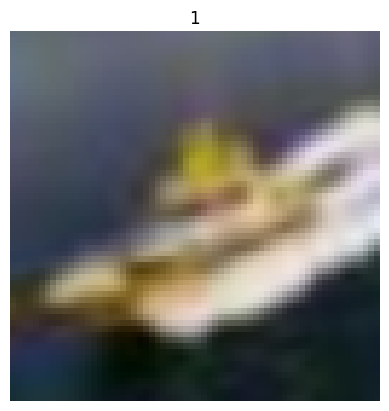

In [37]:
for images, labels in train.take(1):
    plt.imshow(images[30].numpy())
    plt.title(labels[30].numpy())
    plt.axis("off")
    plt.show()



In [38]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [39]:
model=models.Sequential([
        layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',strides = 2,activation='relu',input_shape=(64,64,3)),
        layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout((0.25)),
        layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'),
        layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout((0.2)),
        layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
        layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout((0.2)),

        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32,activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(2,activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,826 (546.20 KB)

 Trainable params: 139,826 (546.20 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.fit(
    train,          # no need to convert to X_train, Y_train
    validation_data=test,
    epochs=10
)


Epoch 1/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 102s 27ms/step - accuracy: 0.7459 - loss: 0.4928 - val_accuracy: 0.8739 - val_loss: 0.2947
Epoch 2/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 89s 26ms/step - accuracy: 0.8692 - loss: 0.3166 - val_accuracy: 0.8945 - val_loss: 0.2548
Epoch 3/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 140s 26ms/step - accuracy: 0.8869 - loss: 0.2772 - val_accuracy: 0.9112 - val_loss: 0.2297
Epoch 4/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 89s 25ms/step - accuracy: 0.8965 - loss: 0.2568 - val_accuracy: 0.9075 - val_loss: 0.2226
Epoch 5/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 86s 25ms/step - accuracy: 0.9028 - loss: 0.2428 - val_accuracy: 0.9212 - val_loss: 0.1970
Epoch 6/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 85s 25ms/step - accuracy: 0.9093 - loss: 0.2299 - val_accuracy: 0.9190 - val_loss: 0.2061
Epoch 7/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - accuracy: 0.9125 - loss: 0.2239 - val_accuracy: 0.9002 - val_loss: 0.2256
Epoch 8/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 88s 26ms/step - accuracy: 0.9159

In [41]:

model.save("my_model.keras")  # new recommended style


In [42]:
import numpy as np
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for x_batch, y_batch in test:
    preds = np.argmax(model.predict(x_batch), axis=1)
    y_pred.extend(preds)
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [43]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10000
           1       0.94      0.91      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

